# Computer Assignment 3

Due Date 12 ตุลาคม  2566 (ก่อนเวลา 23.00 น.)

นักศึกษาต้องสร้าง Classifier โดยเลือกจากที่เรียนในห้องเรียน หรือค้นคว้าจากวารสารทางวิชาการต่างๆ และนำมาทดลองกับ Ionosphere data set ซึ่ง data set ชุดนี้มีทั้งหมด 351 samples โดยแบ่งออกเป็น 2 class คือ good (g) class และ bad (b) class โดยที่ ใน g class มี 224 sample และใน b class มี 127 sample ใน data set ชุดนี้มี features ทั้งหมด 34 features ซึ่ง format ของ data set เป็น ดังนี้

    f1, f2,…,f34 Class

และนักศึกษาต้องทำการ select subset ของ feature ที่ดีที่สุด โดยเลือกใช้วิธีการที่เรียนในห้องเรียน หรือค้นคว้าจากวารสารทางวิชาการก็ได้

          อย่าลืมทำการประเมินประสิทธิภาพของวิธีการนี้ เช่นใช้ 10% cross validation

 

รายงานควรจะประกอบด้วย

          1. รายละเอียดของทฤษฎีหรือวิธีการต่างๆที่ใช้

          2. การออกแบบ algorithm เช่น pseudo-code, flowchart, ฯลฯ

          3. ผลการทดลอง

          4. การวิเคราะห์การทดลอง เช่น ได้ผลตามที่คาดไว้หรือไม่ มีสิ่งประหลาดเกิดขึ้นหรือไม่ บทสรุปที่ได้คืออะไร ฯลฯ

          5. Well documented, structured, modular program listing

          6. อย่าลืมแนบโปรแกรมมาในภาคผนวกด้วย

In [1]:
import pandas as pd

# open the txt file and read its contents
with open('ionosphere.txt', 'r', encoding='ISO-8859-1') as file:
    data = file.read()

# remove first 2 letters
data = data[2:]

# remove '\x00' from the data
data = data.replace('\x00', '')

# create a dataframe from the data
df = pd.DataFrame([row.split() for row in data.split('\n')])

# drop the row with odd index
df = df.drop(df.index[1::2])
# drop the last row
df = df.drop(df.index[-1])

# firt row is the column names
df.columns = df.iloc[0]
# drop the first row
df = df.drop(df.index[0])

column_name = [f"f{i}" for i in range(1, 35)] + ['class']

# rename the columns
df.columns = column_name

# convert the class column to binary
df['class'] = df['class'].replace(['b', 'g'], [0, 1]) # b = 0, g = 1

# convert the data type to float
df = df.astype(float)

# reset the index
df = df.reset_index(drop=True)

df.head()



,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f26,f27,f28,f29,f30,f31,f32,f33,f34,class
0,1.0,0.0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,1.0
1,1.0,0.0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,0.0
2,1.0,0.0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,1.0
3,1.0,0.0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,0.0
4,1.0,0.0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,1.0


## Define variables, constants

In [2]:
N = len(df)
print(f"Number of samples: {N}")

Number of samples: 351


# Feature selection

## T-Test at 99% confident

In [3]:
# import stats
import scipy.stats as stats

def ttest(df, feature):
    """
    Perform t-test on the given feature and return the t-statistic and p-value
    """
    # degrees of freedom
    dof = 2*N - 2

    # group the dataframe by class
    grouped = df.groupby("class")
    # get the groups
    group1 = grouped.get_group(0)[feature]
    group2 = grouped.get_group(1)[feature]
    print(f"Group 1 Mean: {group1.mean()}")
    print(f"Group 1 Variance: {group1.var()}")
    print(f"Group 2 Mean: {group2.mean()}")
    print(f"Group 2 Variance: {group2.var()}")

    # if mean and variance are equal, then the t-statistic is 0
    # and the p-value is 1
    # so, we can return False
    if group1.mean() == group2.mean() and group1.var() == group2.var():
        print("The null hypothesis is accepted")
        print("The feature is rejected")
        return False        

    # perform t-test
    # variance is unknown
    sz_squared = (1/(2*N - 2))*(group1.var() + group2.var())
    sz = sz_squared**0.5
    q = (group1.mean() - group2.mean()) / (sz * (1/N + 1/N))**0.5
    
    # p-value
    p_value = 1 - stats.t.cdf(abs(q), df=dof)
    print(f"p-value: {p_value}")

    # confidence interval
    ci = stats.t.ppf(0.99, dof)
    print(f"Confidence Interval (ci): {ci}")
    print(f"q: {q}")
    print(f"q in (-ci, ci): {-ci < q < ci}")
    if -ci < q < ci:
        print("The null hypothesis is accepted")
        print("The feature is rejected")
        return False
    else:
        print("The null hypothesis is rejected")
        print("The feature is accepted")
        return True


In [4]:
# calculate t-statistic and p-value for each feature
feature_accepted = []

print(f"Degrees of Freedom: {2*N - 2}")
print("T-Test Results\n")

for feature in df.columns[:-1]:
    print(f"Feature: {feature}")
    feature_accepted.append(ttest(df, feature))
    
    print()


Degrees of Freedom: 700
T-Test Results

Feature: f1
Group 1 Mean: 0.6984126984126984
Group 1 Variance: 0.2123174603174603
Group 2 Mean: 1.0
Group 2 Variance: 0.0
p-value: 0.0
Confidence Interval (ci): 2.331686815523585
q: -30.27468926086752
q in (-ci, ci): False
The null hypothesis is rejected
The feature is accepted

Feature: f2
Group 1 Mean: 0.0
Group 1 Variance: 0.0
Group 2 Mean: 0.0
Group 2 Variance: 0.0
The null hypothesis is accepted
The feature is rejected

Feature: f3
Group 1 Mean: 0.2965557936507936
Group 1 Variance: 0.43426932429336507
Group 2 Mean: 0.8344220444444445
Group 2 Variance: 0.04039953938419444
p-value: 0.0
Confidence Interval (ci): 2.331686815523585
q: -44.15599534799275
q in (-ci, ci): False
The null hypothesis is rejected
The feature is accepted

Feature: f4
Group 1 Mean: -0.029780476190476184
Group 1 Variance: 0.4351442735997714
Group 2 Mean: 0.08589719999999999
Group 2 Variance: 0.05682499641489285
p-value: 0.0
Confidence Interval (ci): 2.331686815523585
q: -9

In [5]:
# the accepted features are 
accepted_features = [feature for feature, accepted in zip(df.columns[:-1], feature_accepted) if accepted]
print(f"Accepted Features: {accepted_features}")

print(f"Rejected Features: {[feature for feature in df.columns[:-1] if feature not in accepted_features]}")

Accepted Features: ['f1', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f25', 'f27', 'f28', 'f29', 'f31', 'f32', 'f33', 'f34']
Rejected Features: ['f2', 'f24', 'f26', 'f30']


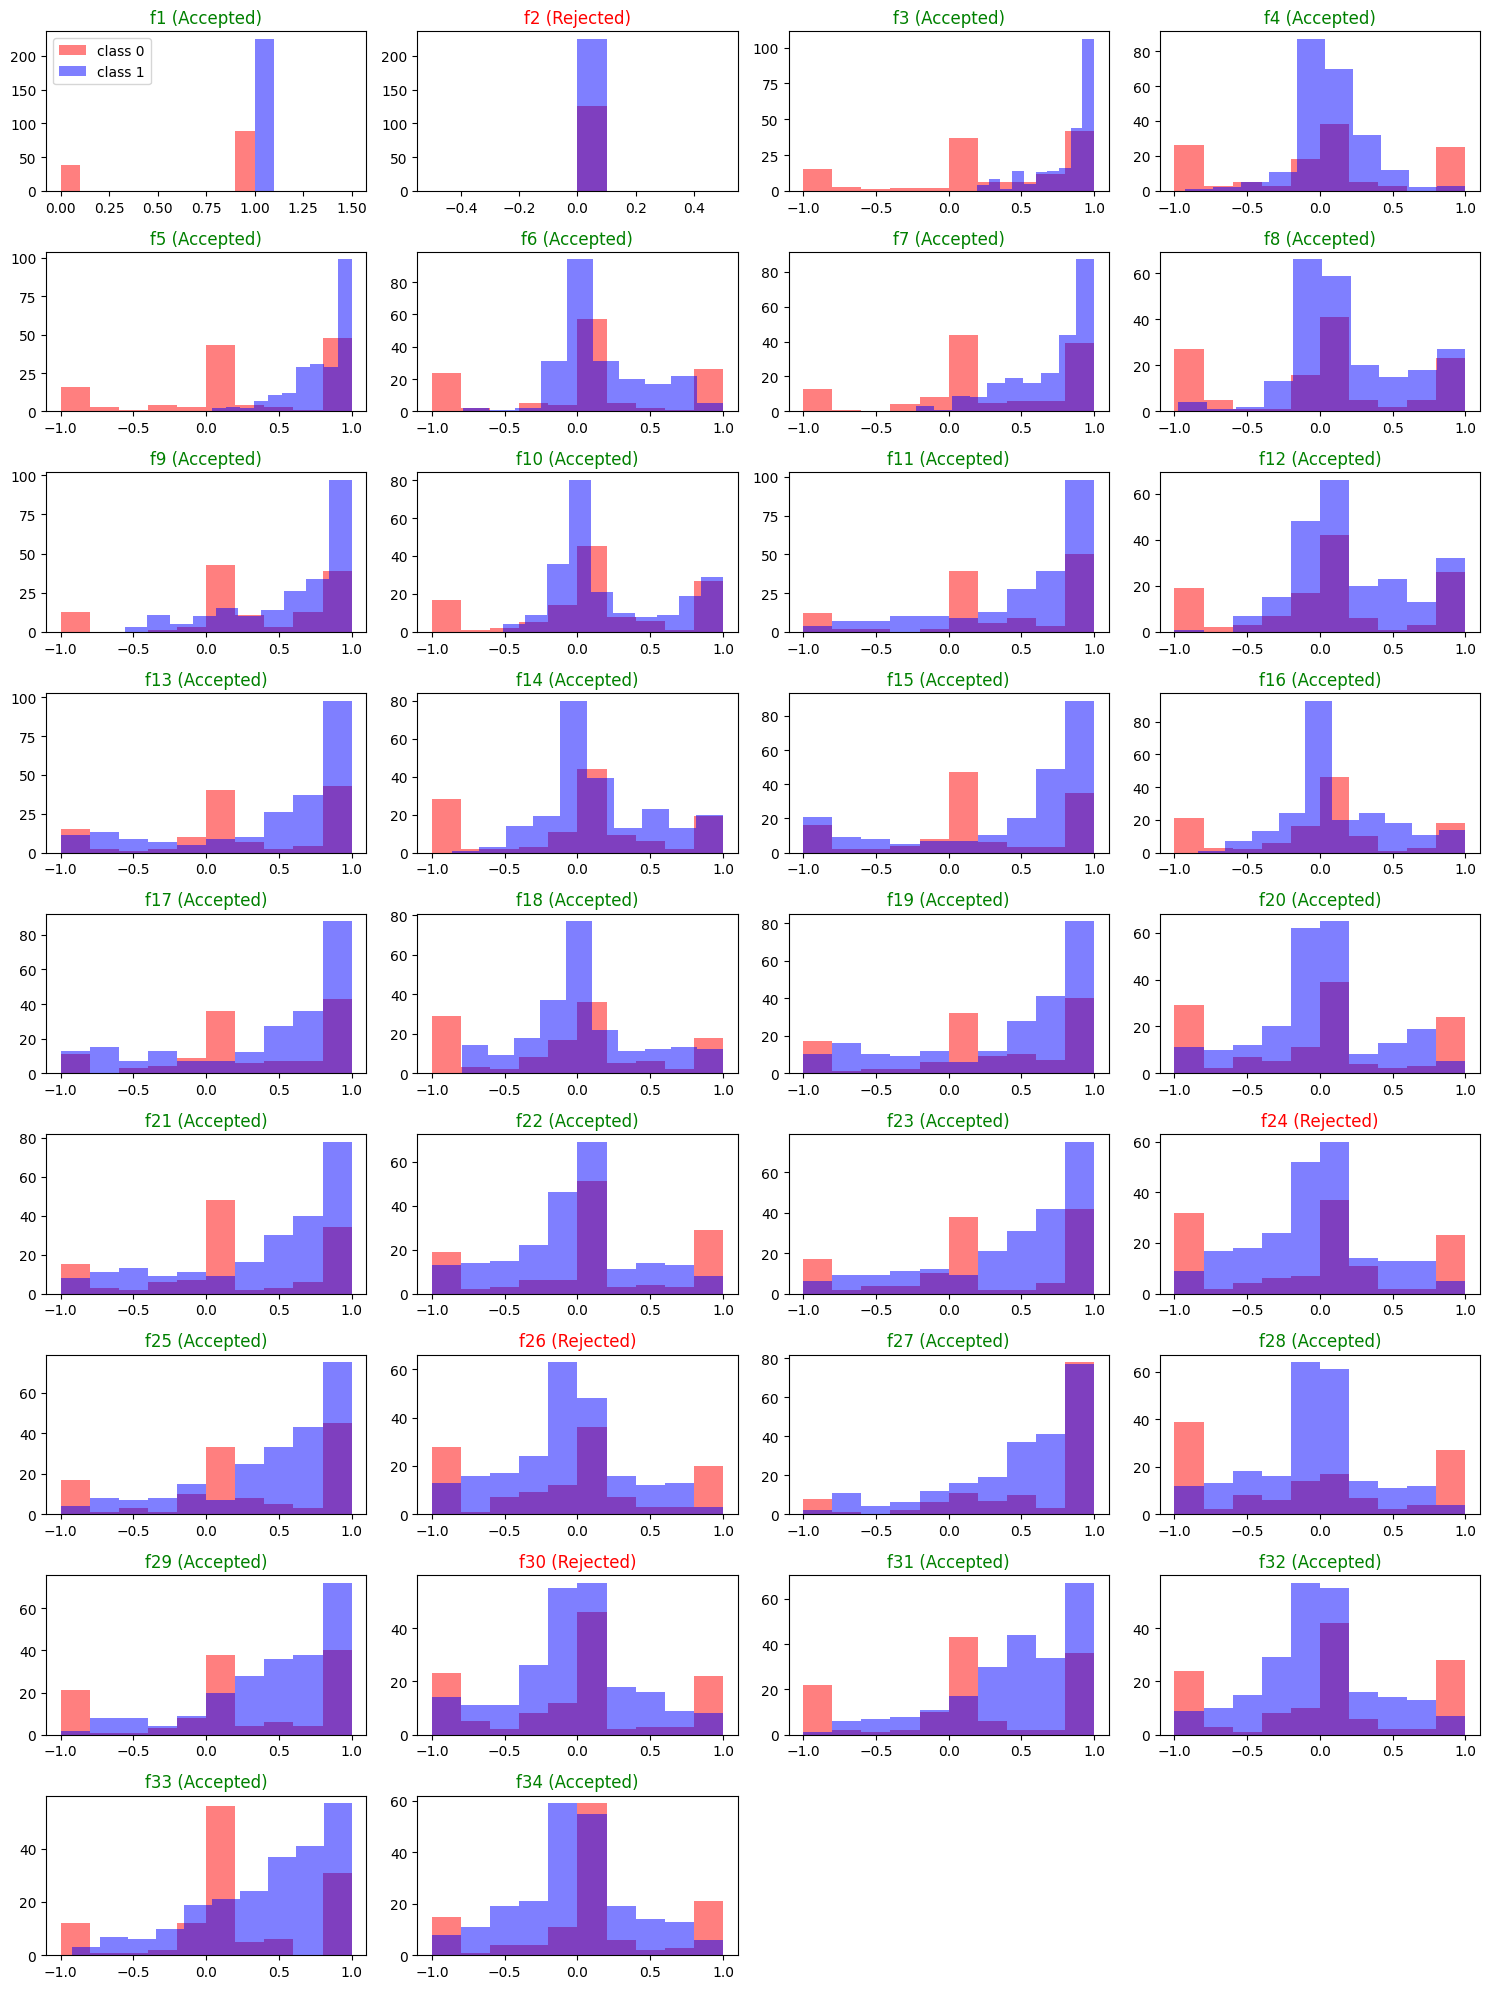

In [6]:
import matplotlib.pyplot as plt

# make sure the column 'class' is present in the dataframe
if 'class' not in df.columns:
    df.columns = df.columns[:-1].tolist() + ['class']

# group the dataframe by class
grouped = df.groupby("class")

# number of rows = ceil(number of features / 4)
rows = (len(df.columns) - 1) // 4 + 1

# create subplots
fig, axs = plt.subplots(nrows=rows, ncols=4, figsize=(15, 20))

# plot histograms for each feature
for i, feature in enumerate(df.columns[:-1]):
    row = i // 4
    col = i % 4
    for name, group in grouped:
        axs[row, col].hist(group[feature], alpha=0.5, \
                           label=f"class {int(name)}", color='blue' if int(name) == 1 else 'red')
        if row == 0 and col == 0:
            axs[row, col].legend()
    if feature in accepted_features: # color the title green if the feature is accepted
        axs[row, col].set_title(f"{feature} (Accepted)", color='green')
    else:
        axs[row, col].set_title(f"{feature} (Rejected)", color='red')

# remove the last 2 subplots
fig.delaxes(axs[8, 3])
fig.delaxes(axs[8, 2])

plt.tight_layout()
plt.savefig('histograms.png')
plt.show()
